# Experiment description
## Hypothesis: 
We can train sepp model at city aggregation using two-weeks data

## Method: 

Train model using two-weeks data (2017-01-01 to 2017-01-16) at city scope. Try different parameters to achieve model convergence:
- Parameters configuration successful on experiment 04 (one week training)


In [1]:
%matplotlib inline
import pandas as pd
import pickle
import dateutil.parser
import pyproj
import open_cp
import open_cp.sepp as sepp
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import import_ipynb
import training_sepp_builtin

In [3]:
def selectDataPrediction(nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc = df[df["LOCALIDAD"]==nameLoc]
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_crime = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    
    #Generando Grilla para los algoritmos. 
    maxx = max(xcoords)
    minx = min(xcoords)
    maxy = max(ycoords)
    miny = min(ycoords)

    region = open_cp.RectangularRegion(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy)
    
    return (points_crime,region)


In [4]:
def selectDataTraining(df,nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_train = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    return (points_train,timestamps,xcoords, ycoords)

In [5]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

def trainModel_parameters(df,nameLoc,dateIni,dateEnd,parameters,iterations=10):
    points_train,timestamps,xcoords, ycoords = selectDataTraining(df,nameLoc,dateIni,dateEnd)
    plt.scatter(xcoords, ycoords)
    print([timestamps])
    trainer = sepp.SEPPTrainer()
    trainer._initial_time_bandwidth = parameters['time_bw']
    trainer._initial_space_bandwidth = parameters['space_bw']
    trainer._time_cutoff = parameters['time_cutoff']
    trainer._space_cutoff = parameters['space_cutoff']
    print('time BW set on: ',trainer._initial_time_bandwidth)
    print('space BW set on: ',trainer._initial_space_bandwidth)
    print('time cutoff set on: ',trainer._time_cutoff)
    print('space cutoff set on: ',trainer._space_cutoff)
    print('Number of realizations: ',iterations)
    trainer.data = points_train    
    while True:  
        try:
            predictor = trainer.train()
            print("succesful training!")
            break
        except (RuntimeError, ValueError) as e:
            print(e)
            pass
        iterations = iterations - 1
        if iterations == 0:
            return "not succesfull training"
    return predictor 

In [6]:
def load_model(localidad, train_date):
    custom_path = path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+train_date+'.pkl'
    infile = open(custom_path,'rb')
    modelCrime = pickle.load(infile)
    infile.close()
    return modelCrime

In [7]:
def run_prediction(localidad,modelCrime,predict_time):
    points_crime,region = selectData(localidad,initial_date_prediction,final_date_prediction)
    modelCrime.data = points_crime 
    prediction = modelCrime.predict(predict_time)
    gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 150, 150)
    hitrates = open_cp.evaluation.hit_rates(gridpred, points_crime, [0.01,0.1])
    return gridpred, hitrates

In [8]:
def plot_gridpred(localidad,predict_time,gridpred):
    fig, ax = plt.subplots(figsize=(20,10))
    m = ax.pcolormesh(*gridpred.mesh_data(), gridpred.intensity_matrix, cmap="CMRmap_r")
    ax.set_title("Predicción localidad: "+localidad+'; fecha: '+str(predict_time))
    fig.colorbar(m, ax=ax)

## Select data

In [9]:
path = '/u01/user8/Documents/Riñas'

In [10]:
df = pd.read_csv(path+'/datasets/verify_enrich_nuse_29112019.csv')

In [14]:
initial_date = '2017-01-01'
final_date = '2017-01-15'

## Training experiments

### Scenario 1: successful parameters used on experiment 04
time_cutoff = [30, 50, 70, 90, 120]

#### Parameter = 30

In [23]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700150   2017-01-14 19:33:00
700151   2017-01-14 13:49:00
700153   2017-01-14 21:56:00
700154   2017-01-14 12:50:00
700158   2017-01-14 12:40:00
Name: FECHA_HORA_TS, Length: 13239, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  30
space cutoff set on:  500
Number of realizations:  10
succesful training!


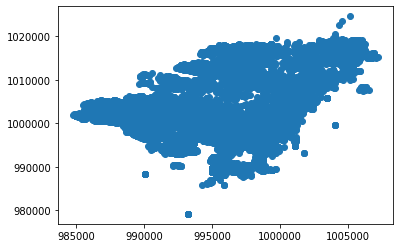

In [24]:
localidad = 'city'
parameters['time_cutoff'] = 30
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results:
- Number of realizations: 1
- Average time elapsed for realization: 35 min
- No errors

#### Parameter = 50

In [15]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700150   2017-01-14 19:33:00
700151   2017-01-14 13:49:00
700153   2017-01-14 21:56:00
700154   2017-01-14 12:50:00
700158   2017-01-14 12:40:00
Name: FECHA_HORA_TS, Length: 13239, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  50
space cutoff set on:  500
Number of realizations:  10
succesful training!


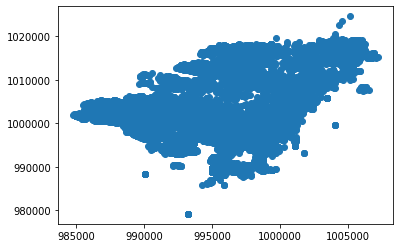

In [16]:
localidad = 'city'
parameters['time_cutoff'] = 50
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 45 min
- No errors

#### Parameter = 70

In [17]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700150   2017-01-14 19:33:00
700151   2017-01-14 13:49:00
700153   2017-01-14 21:56:00
700154   2017-01-14 12:50:00
700158   2017-01-14 12:40:00
Name: FECHA_HORA_TS, Length: 13239, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  70
space cutoff set on:  500
Number of realizations:  10
succesful training!


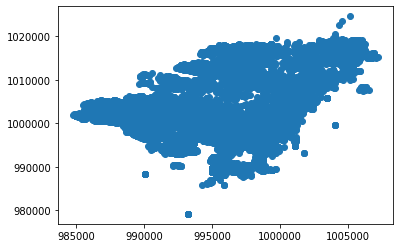

In [18]:
localidad = 'city'
parameters['time_cutoff'] = 70
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 40 min
- No errors

#### Parameter = 90

In [19]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700150   2017-01-14 19:33:00
700151   2017-01-14 13:49:00
700153   2017-01-14 21:56:00
700154   2017-01-14 12:50:00
700158   2017-01-14 12:40:00
Name: FECHA_HORA_TS, Length: 13239, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  90
space cutoff set on:  500
Number of realizations:  10
0 standard deviation: [19.59637776  0.          0.        ]
0 standard deviation: [19.54283053  0.          0.        ]
0 standard deviation: [19.71224385  0.          0.        ]
succesful training!


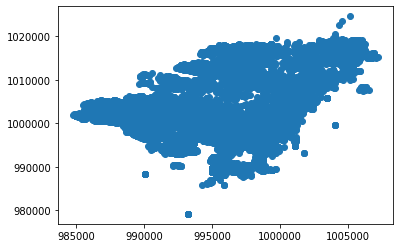

In [20]:
localidad = 'city'
parameters['time_cutoff'] = 90
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 4 (one successful)
- Average time elapsed for realization: 25 min
- 0 standard deviation errors

#### Parameter = 120

In [21]:
#default parameters
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":172800,"space_cutoff":500}

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
700150   2017-01-14 19:33:00
700151   2017-01-14 13:49:00
700153   2017-01-14 21:56:00
700154   2017-01-14 12:50:00
700158   2017-01-14 12:40:00
Name: FECHA_HORA_TS, Length: 13239, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  50
time cutoff set on:  120
space cutoff set on:  500
Number of realizations:  10
0 standard deviation: [29.41744564  0.          0.        ]
0 standard deviation: [29.24508677  0.          0.        ]
0 standard deviation: [29.4944204  0.         0.       ]
0 standard deviation: [29.32685202  0.          0.        ]
0 standard deviation: [29.16648597  0.          0.        ]
0 standard deviation: [29.2181456  0.         0.       ]
0 standard deviation: [29.60052  0.       0.     ]
0 standard deviation: [29.28312775  0.          

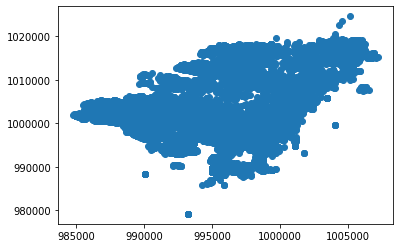

In [22]:
localidad = 'city'
parameters['time_cutoff'] = 120
iterations = 10
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,parameters,iterations)
if city_predictor != "not succesfull training":    
    experiment_name = str(localidad)+'_'+initial_date+'_'+final_date+'_time_cutoff_'+str(parameters['time_cutoff'])
    city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
    pickle.dump(city_predictor, city_outfile)
    city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 12 min
- 0 standard deviation errors